In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

/Users/didi/Documents/soda/venv/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [2]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    return df

In [3]:
%%time
train_df = load_df("/Users/didi/Documents/zx/Github/kaggle/ga-customer-revenue-prediction/input/train_v2.csv.head")
test_df = load_df("/Users/didi/Documents/zx/Github/kaggle/ga-customer-revenue-prediction/input/test_v2.csv.head")

Loaded train_v2.csv.head. Shape: (999, 59)
Loaded test_v2.csv.head. Shape: (999, 59)
CPU times: user 1.14 s, sys: 118 ms, total: 1.26 s
Wall time: 1.3 s


In [4]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not ava

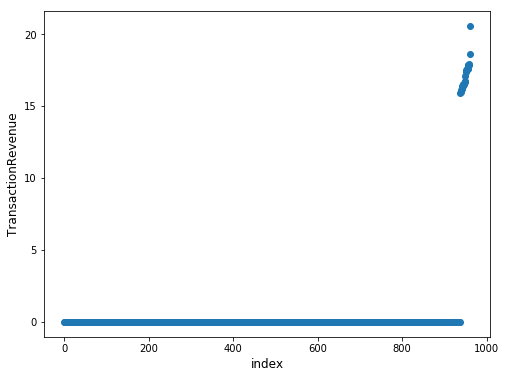

In [18]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [23]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()

print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / (train_df.shape[0] + 0.00001))
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / (gdf.shape[0] + 0.000001))

('Number of instances in train set with non-zero revenue : ', 24, ' and ratio is : ', 0.024024023783543305)
('Number of unique customers with non-zero revenue : ', 24, 'and the ratio is : ', 0.02494802492209145)


In [24]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

('Number of unique visitors in train set : ', 962, ' out of rows : ', 999)
('Number of unique visitors in test set : ', 954, ' out of rows : ', 999)
('Number of common visitors in train and test set : ', 2)


In [36]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['date',
 'socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [37]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]

